In [1]:
import logging
import itertools

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
import scipy.stats as stats
import pandas as pd
import pymc3 as pm

from dask.distributed import Client, LocalCluster
import dask.delayed

# Dask Cluster

In [3]:
# cluster = LocalCluster(
#     n_workers=12, 
#     threads_per_worker=1, 
#     processes=True, 
#     silence_logs=logging.ERROR
# )
# client = Client(cluster)
# client


import coiled

# coiled.create_software_environment(
#    name="my-pip-env",
#    pip=["dask[complete]", "pandas==1.1.5", "scipy==1.5.4"],
# )

cluster = coiled.Cluster(
    name="randomization_unit_analysis_unit",
    n_workers=10,
    worker_memory='8GiB',
    worker_cpu=4,
)

client = Client(cluster)
client


# client = Client('tcp://127.0.0.1:57092')
# client

# client.restart()
# client.shutdown()
# client.close()

Creating Cluster. This takes about a minute ...Dashboard: http://ec2-3-19-245-79.us-east-2.compute.amazonaws.com:8787


/Users/ianwhitestone/.pyenv/versions/3.7.6/lib/python3.7/site-packages/distributed/client.py:1128: VersionMismatchWarning: Mismatched versions found

+-------------+---------------+---------------+---------------+
| Package     | client        | scheduler     | workers       |
+-------------+---------------+---------------+---------------+
| blosc       | None          | 1.10.2        | 1.10.2        |
| dask        | 2020.12.0     | 2021.02.0     | 2021.02.0     |
| distributed | 2020.12.0     | 2021.02.0     | 2021.02.0     |
| lz4         | None          | 3.1.3         | 3.1.3         |
| numpy       | 1.19.4        | 1.20.0        | 1.20.0        |
| python      | 3.7.6.final.0 | 3.7.9.final.0 | 3.7.9.final.0 |
+-------------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never r

# Simulating A/A Test - User Level Randomization with Session 

## Simulation Function

In [2]:
# dask function itself will run multiple experiments to reduce the number
# of tasks in the graph
def _simulate_experiments(df, randomization_unit, num_experiments=10, test_type='frequentist'):
    output = []
    for x in range(0, num_experiments):
        if randomization_unit == 'user':
            users = df.user.unique()
            users_df = pd.DataFrame({'user': users, 'assignment': np.random.randint(0, 2, size=len(users))})
            df_w_assignments = pd.merge(df, users_df, how='inner', on='user')
        elif randomization_unit == 'session':
            df_w_assignments = df.copy()
            df_w_assignments['assignment'] = np.random.randint(0, 2, size=df.shape[0])
        else:
            raise ValueError("randomization unit must be 'session' or 'user'")

        control_samples = df_w_assignments[df_w_assignments.assignment == 0].session_converted.count()
        control_successes = df_w_assignments[df_w_assignments.assignment == 0].session_converted.sum()

        test_samples = df_w_assignments[df_w_assignments.assignment == 1].session_converted.count()
        test_successes = df_w_assignments[df_w_assignments.assignment == 1].session_converted.sum()
        
        if test_type == 'frequentist':
            zscore, p_value = two_proportions_test(
                control_successes, 
                control_samples,
                test_successes, 
                test_samples,
            )
            output.append(p_value)
        elif test_type == 'frequentist_delta':
            results_df = (
                df_w_assignments
                .groupby(['user', 'assignment'])
                .session_converted
                .agg(
                    total_sessions='count',
                    total_sessions_converted='sum'
                )
                .reset_index()
            )
            
            zscore, p_value = two_proportions_test_delta_method(
                results_df[results_df.assignment == 0].total_sessions_converted,
                results_df[results_df.assignment == 0].total_sessions, 
                results_df[results_df.assignment == 1].total_sessions_converted,
                results_df[results_df.assignment == 1].total_sessions, 
            )
            output.append(p_value)
        elif test_type == 'bayesian':
            p_test_gt_control, p_control_gt_test = bayesian_rate_comparison(
                control_successes, control_samples, test_successes, test_samples
            )
            output.append((p_test_gt_control, p_control_gt_test))
        else:
            raise ValueError(
                "test type must be 'frequentist' or 'bayesian' or 'frequentist_delta'"
            )
    return output


def simulate_experiments(
    df, 
    num_experiments=10000, 
    num_experiments_per_task=100, 
    randomization_unit='user',
    test_type='frequentist'
):
    
    delayed_output = []
    scattered_df = client.scatter(df)
    for x in range(0, round(num_experiments/num_experiments_per_task)):
        _delayed_output = dask.delayed(_simulate_experiments)(
            scattered_df, 
            randomization_unit, 
            num_experiments_per_task,
            test_type
        )
        delayed_output.append(_delayed_output)
    
    output = dask.compute(*delayed_output)
    return list(itertools.chain.from_iterable(output))

## Creating Data

```python

### SCENARIO 2 ###
## Avg of ~10 sessions per user
## gives a 8% false positive rate
sessions_per_user = np.random.geometric(0.1, size=num_users)
avg_conversion_rate = 0.2
rates = avg_conversion_rate*1/5 + avg_conversion_rate*4/5*np.exp(-0.1*(sessions_per_user - 1))

### SCENARIO 2 ###
# Average of 2 sessions per user
# gives a <5% false positive rate
sessions_per_user = np.random.geometric(0.5, size=num_users)
avg_conversion_rate = 0.2
rates = avg_conversion_rate*1/5 + avg_conversion_rate*4/5*np.exp(-0.1*(sessions_per_user - 1))

### SCENARIO 3 ###
# ~10 sessions per user, no difference in conversion rates
# gives a <5% false positive rate.
sessions_per_user = np.random.geometric(0.1, size=num_users)
avg_conversion_rate = 0.2
rates = avg_conversion_rate
```

Building dataset
Average sessions per user 9.77


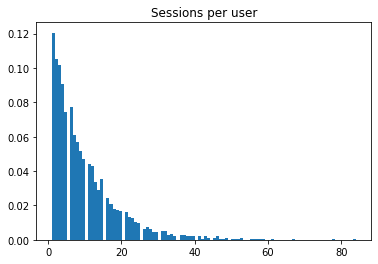

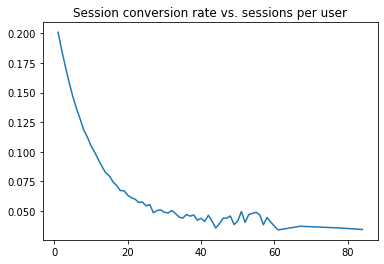

In [3]:
print("Building dataset")
num_users = 5000

sessions_per_user = np.random.geometric(0.1, size=num_users)

avg_conversion_rate = 0.2
rates = avg_conversion_rate*1/5 + avg_conversion_rate*4/5*np.exp(-0.1*(sessions_per_user - 1))

a = rates*1000
b = 1000 - rates*1000
conversion_rates = np.random.beta(a, b, size=num_users);


plt.figure(0);
plt.title('Sessions per user')
plt.hist(sessions_per_user, density=True, bins=100);
df = pd.DataFrame({'spu': sessions_per_user, 'cv': conversion_rates})
gdf = df.groupby('spu').cv.mean().reset_index(name='mean_cv')

plt.figure(1);
plt.title('Session conversion rate vs. sessions per user');
plt.plot(gdf[gdf.spu <= 100].spu, gdf[gdf.spu <= 100].mean_cv);

data = {
    'user': [],
    'session_id': [],
    'session_converted': []
}

for user_id, num_sessions in enumerate(sessions_per_user):
    conversion_rate = conversion_rates[user_id]
    for session_id in range(1, num_sessions+1):
        session_converted = np.random.choice([0, 1], p=[1-conversion_rate, conversion_rate])
        data['user'].append(user_id)
        data['session_id'].append(f"{user_id}-{session_id}")
        data['session_converted'].append(session_converted)

df = pd.DataFrame(data)
print(f"Average sessions per user {sessions_per_user.mean():0.2f}")

## Frequentist Experiments

In [ ]:
print("Running Frequentist tests")
for i, ru in enumerate(['session', 'user']):
    print(f"{ru.capitalize()} Level Randomization:")
    p_values = simulate_experiments(
        df, 
        num_experiments=10000, 
        num_experiments_per_task=250,
        randomization_unit=ru,
        test_type='frequentist'
    )
    
    false_positives = [
        1 for p_value in p_values if p_value <= 0.05
    ]

    print(
        f"Detected {len(false_positives)} false positives out of {len(p_values)} trials"
        f" ({len(false_positives)/len(p_values):0.2%} FPR)"
    )

    plt.figure(i);
    plt.hist(p_values, bins=50);
    plt.title(f'Distribution of p-values with {ru} level randomization');

## Frequentist Experiments - DELTA METHOD

In [ ]:
print("Running Frequentist tests")
for i, ru in enumerate(['session', 'user']):
    print(f"{ru.capitalize()} Level Randomization:")
    p_values = simulate_experiments(
        df, 
        num_experiments=10000, 
        num_experiments_per_task=250,
        randomization_unit=ru,
        test_type='frequentist_delta'
    )
    
    false_positives = [
        1 for p_value in p_values if p_value <= 0.05
    ]

    print(
        f"Detected {len(false_positives)} false positives out of {len(p_values)} trials"
        f" ({len(false_positives)/len(p_values):0.2%} FPR)"
    )

    plt.figure(i);
    plt.hist(p_values, bins=50);
    plt.title(f'Distribution of p-values with {ru} level randomization');

## Bayesian Experiments

In [ ]:
print("Running Bayesian tests")
for i, ru in enumerate(['session', 'user']):
    print(f"{ru.capitalize()} Level Randomization:")
    bayesian_probas = simulate_experiments(
        df, 
        num_experiments=10000, 
        num_experiments_per_task=250, 
        randomization_unit=ru,
        test_type='bayesian'
    )
    
    false_positives = [
        1 for p_t, p_c in bayesian_probas if p_t >= 0.975 or p_c >= 0.975
    ]
    
    bayesian_fpr = (
        len(false_positives) 
        / len(bayesian_probas)
    )

    print(
        f"Detected {len(false_positives)} false positives out of {len(bayesian_probas)} trials"
        f" ({len(false_positives)/len(bayesian_probas):0.2%} FPR)"
    )

    plt.figure(i);
    plt.hist([p[0] for p in bayesian_probas], bins=50);
    plt.title(f'Distribution of p_test_gt_control with {ru} level randomization');

# Improved Variance Estimation

## Delta Method

In [4]:
users = df.user.unique()
users_df = pd.DataFrame({'user': users, 'assignment': np.random.randint(0, 2, size=len(users))})
df_w_assignments = pd.merge(df, users_df, how='inner', on='user')

results_df = df_w_assignments.groupby(['user', 'assignment']).session_converted.agg(
    total_sessions='count',
    total_sessions_converted='sum'
).reset_index()

results_df

,user,assignment,total_sessions,total_sessions_converted
0,0,1,7,0
1,1,0,2,0
2,2,1,7,1
3,3,0,3,1
4,4,1,4,1
...,...,...,...,...
4995,4995,0,11,0
4996,4996,1,6,0
4997,4997,1,11,0
4998,4998,0,20,2


**Variable Notation**

* `i = user indicator`, there are `n` total users
* `N = # of sessions`
* `Y = session conversion indicator`
* `S = total # of sessions converted`
* `Y_hat = total # of sessions converted / total # of sessions`
* `tau = difference in observed ratios`

In [5]:

N_ic = results_df[results_df.assignment == 0].total_sessions
N_it = results_df[results_df.assignment == 1].total_sessions
S_ic = results_df[results_df.assignment == 0].total_sessions_converted
S_it = results_df[results_df.assignment == 1].total_sessions_converted

Y_hat_c = np.sum(S_ic) / np.sum(N_ic)
Y_hat_t = np.sum(S_it) / np.sum(N_it)

n = N_it.shape[0] + N_ic.shape[0]

tau = Y_hat_t - Y_hat_c
tau

0.0023013062112093308

In [6]:
# plt.hist(S_ic, bins=100, density=True);

# var_tau = np.cov(S_ic, N_ic)[0][1]
# np.var(S_ic)


e_c2 = (
    np.var(S_ic)/np.mean(N_ic)**2 
    + np.mean(S_ic)**2/np.mean(N_ic)**4*np.var(N_ic) 
    - 2*np.mean(S_ic)/np.mean(N_ic)**3*np.cov(S_ic, N_ic)[0][1]
)

e_t2 = (
    np.var(S_it)/np.mean(N_it)**2 
    + np.mean(S_it)**2/np.mean(N_it)**4*np.var(N_it) 
    - 2*np.mean(S_it)/np.mean(N_it)**3*np.cov(S_it, N_it)[0][1]
)

var_tau = n/2**-1*(e_c2 + e_t2)
var_tau

4.105742232546132e-06

In [41]:
N = N_it.sum() + N_ic.sum()
p = N_it.sum() / N
N_hat = N/n

mu = Y_hat_c
var_tau_g = n**-1*(
    np.var((S_it-N_it*(mu + tau))/(p*N_hat))
    + np.var((S_ic-N_ic*mu)/((1-p)*N_hat))
)
var_tau_g

1.6424698228381607e-05

In [93]:
## bootstrap variance of tau

# actual tau
test_conversion = results_df[results_df.assignment == 0].total_sessions_converted.sum() / results_df[results_df.assignment == 0].total_sessions.sum()
control_conversion = results_df[results_df.assignment == 1].total_sessions_converted.sum() / results_df[results_df.assignment == 1].total_sessions.sum()
tau_actual = test_conversion - control_conversion


# generate permutations under the null hypothesis (P_c = P_t)
results = []
num_users = results_df.shape[0]

for _ in range(0, 5000):
    # bootstrapped sample
    sample_df = results_df.sample(num_users, replace=True)
    # randomly re-assign groups
    sample_df['assignment'] = np.random.randint(0, 2, size=num_users)
    
    # calculate tau
    N_ic = sample_df[sample_df.assignment == 0].total_sessions
    N_it = sample_df[sample_df.assignment == 1].total_sessions
    S_ic = sample_df[sample_df.assignment == 0].total_sessions_converted
    S_it = sample_df[sample_df.assignment == 1].total_sessions_converted
    tau = S_it.sum() / N_it.sum() - S_ic.sum() / N_ic.sum()
    
    results.append(tau)

In [94]:
bootstrapped_p_value = 1 - len([bs_tau for bs_tau in results if np.abs(tau_actual) >= bs_tau])/len(results)
bootstrapped_p_value

0.18400000000000005

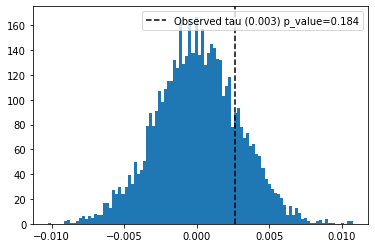

In [95]:
plt.hist(results, bins=100);
# plt.axvline(np.percentile(results, 2.5), label='p2.5', linestyle='--', color='k');
# plt.axvline(np.percentile(results, 97.5), label='p97.5', linestyle='--', color='k');
plt.axvline(tau_actual, label=f'Observed tau ({tau_actual:0.3f}) p_value={bootstrapped_p_value:0.3f}', linestyle='--', color='k');

plt.legend();

In [102]:
def bootstrapped_method(
    user_conversion_counts_a, 
    user_session_counts_a,
    user_conversion_counts_b,
    user_session_counts_b,
    results_df
):
    num_users = results_df.shape[0]
    tau_actual = (
        (user_conversion_counts_b.sum()/user_session_counts_b.sum()) - 
        (user_conversion_counts_a.sum()/user_session_counts_a.sum())
    )
    results = []
    for _ in range(0, 5000):
        # bootstrapped sample
        sample_df = results_df.sample(num_users, replace=True)
        # randomly re-assign groups
        sample_df['assignment'] = np.random.randint(0, 2, size=num_users)

        # calculate tau
        N_ic = sample_df[sample_df.assignment == 0].total_sessions
        N_it = sample_df[sample_df.assignment == 1].total_sessions
        S_ic = sample_df[sample_df.assignment == 0].total_sessions_converted
        S_it = sample_df[sample_df.assignment == 1].total_sessions_converted
        tau = S_it.sum() / N_it.sum() - S_ic.sum() / N_ic.sum()

        results.append(tau)
    
    bootstrapped_p_value = 1 - len([bs_tau for bs_tau in results if np.abs(tau_actual) >= bs_tau])/len(results)
    return bootstrapped_p_value

def two_proportions_test_g_method(
    user_conversion_counts_a, 
    user_session_counts_a,
    user_conversion_counts_b,
    user_session_counts_b,
):

    Y_hat_c = np.sum(user_conversion_counts_a) / np.sum(user_session_counts_a)
    Y_hat_t = np.sum(user_conversion_counts_b) / np.sum(user_session_counts_b)

    n = user_session_counts_b.shape[0] + user_session_counts_a.shape[0]

    tau = Y_hat_t - Y_hat_c

    N = user_session_counts_a.sum() + user_session_counts_b.sum()
    p = user_session_counts_b.sum() / N
    N_hat = N/n

    mu = Y_hat_c
    var_tau_g = n**-1*(
        np.var((S_it-N_it*(mu + tau))/(p*N_hat))
        + np.var((S_ic-N_ic*mu)/((1-p)*N_hat))
    )


    zscore = np.abs(tau) / np.sqrt(var_tau_g)
    one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(zscore)
    pvalue = one_side * 2    
    return zscore, pvalue, var_tau_g

def two_proportions_test_delta_method(
    user_conversion_counts_a, 
    user_session_counts_a,
    user_conversion_counts_b,
    user_session_counts_b,
):

    Y_hat_c = np.sum(user_conversion_counts_a) / np.sum(user_session_counts_a)
    Y_hat_t = np.sum(user_conversion_counts_b) / np.sum(user_session_counts_b)

    n = user_session_counts_b.shape[0] + user_session_counts_a.shape[0]

    tau = Y_hat_t - Y_hat_c
    e_c2 = (
        np.var(user_conversion_counts_a)/np.mean(user_session_counts_a)**2 
        + np.mean(user_conversion_counts_a)**2/np.mean(user_session_counts_a)**4*np.var(user_session_counts_a) 
        - 2*np.mean(user_conversion_counts_a)/np.mean(user_session_counts_a)**3*np.cov(user_conversion_counts_a, user_session_counts_a)[0][1]
    )

    e_t2 = (
        np.var(user_conversion_counts_b)/np.mean(user_session_counts_b)**2 
        + np.mean(user_conversion_counts_b)**2/np.mean(user_session_counts_b)**4*np.var(user_session_counts_b) 
        - 2*np.mean(user_conversion_counts_b)/np.mean(user_session_counts_b)**3*np.cov(user_conversion_counts_b, user_session_counts_b)[0][1]
    )

    var_tau = (e_c2 + e_t2)/n

    zscore = np.abs(tau) / np.sqrt(var_tau)
    one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(zscore)
    pvalue = one_side * 2    
    return zscore, pvalue, var_tau

def two_proportions_test(success_a, size_a, success_b, size_b):
    """
    http://ethen8181.github.io/machine-learning/ab_tests/frequentist_ab_test.html#Comparing-Two-Proportions
    
    A/B test for two proportions;
    given a success a trial size of group A and B compute its zscore and pvalue
    
    Parameters
    ----------
    success_a, success_b : int
        Number of successes in each group
        
    size_a, size_b : int
        Size, or number of observations in each group
    
    Returns
    -------
    zscore : float
        test statistic for the two proportion z-test

    pvalue : float
        p-value for the two proportion z-test
    """
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    prop_pooled = (success_a + success_b) / (size_a + size_b)
    var = prop_pooled * (1 - prop_pooled) * (1 / size_a + 1 / size_b)
    zscore = np.abs(prop_b - prop_a) / np.sqrt(var)
    one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(zscore)
    pvalue = one_side * 2
    return zscore, pvalue, var


In [97]:
output_1 = []
output_2 = []
output_3 = []

users = df.user.unique()
for x in range(0, 1000):
    users_df = pd.DataFrame({'user': users, 'assignment': np.random.randint(0, 2, size=len(users))})
    df_w_assignments = pd.merge(df, users_df, how='inner', on='user')
    
    control_samples = df_w_assignments[df_w_assignments.assignment == 0].session_converted.count()
    control_successes = df_w_assignments[df_w_assignments.assignment == 0].session_converted.sum()

    test_samples = df_w_assignments[df_w_assignments.assignment == 1].session_converted.count()
    test_successes = df_w_assignments[df_w_assignments.assignment == 1].session_converted.sum()

    
    zscore, p_value, var = two_proportions_test(
        control_successes, 
        control_samples,
        test_successes, 
        test_samples,
    )
    output_1.append((p_value, var))


    results_df = (
        df_w_assignments
        .groupby(['user', 'assignment'])
        .session_converted
        .agg(
            total_sessions='count',
            total_sessions_converted='sum'
        )
        .reset_index()
    )

    zscore, p_value, var = two_proportions_test_delta_method(
        results_df[results_df.assignment == 0].total_sessions_converted,
        results_df[results_df.assignment == 0].total_sessions, 
        results_df[results_df.assignment == 1].total_sessions_converted,
        results_df[results_df.assignment == 1].total_sessions, 
    )
    output_2.append((p_value, var))
    
    zscore, p_value, var = two_proportions_test_g_method(
        results_df[results_df.assignment == 0].total_sessions_converted,
        results_df[results_df.assignment == 0].total_sessions, 
        results_df[results_df.assignment == 1].total_sessions_converted,
        results_df[results_df.assignment == 1].total_sessions, 
    )
    output_3.append((p_value, var))

In [98]:
print(
    f"Mean variance normal method: {np.mean([x[1] for x in output_1])}"
)
print(
    f"Mean p-value normal method: {np.mean([x[0] for x in output_1])}"
)
print(
    f"FPR normal method: {len([x[0] for x in output_1 if x[0] <= 0.05]) / len(output_1):0.2%}"
)

print(
    f"Mean variance delta method: {np.mean([x[1] for x in output_2])}"
)
print(
    f"Mean p-value delta method: {np.mean([x[0] for x in output_2])}"
)
print(
    f"FPR delta method: {len([x[0] for x in output_2 if x[0] <= 0.05]) / len(output_2):0.2%}"
)


print(
    f"Mean variance g method: {np.mean([x[1] for x in output_3])}"
)
print(
    f"Mean p-value g method: {np.mean([x[0] for x in output_3])}"
)
print(
    f"FPR g method: {len([x[0] for x in output_3 if x[0] <= 0.05]) / len(output_3):0.2%}"
)

Mean variance normal method: 6.525860479714273e-06
Mean p-value normal method: 0.4510774490744131
FPR normal method: 8.70%
Mean variance delta method: 4.107705173302077e-06
Mean p-value delta method: 0.379912847325314
FPR delta method: 17.70%
Mean variance g method: 1.670469302686217e-05
Mean p-value g method: 0.5993761904100504
FPR g method: 0.90%


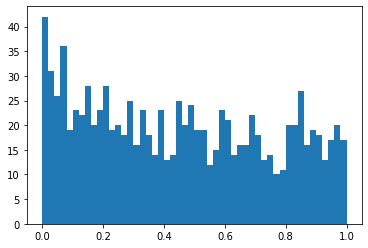

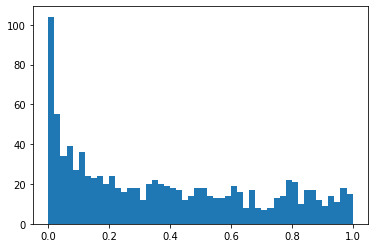

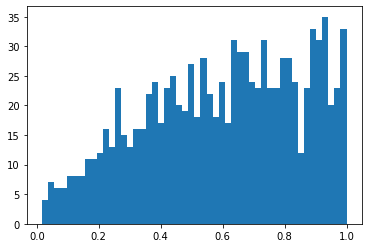

In [99]:
plt.figure(0);
plt.hist([x[0] for x in output_1], bins=50);
plt.figure(1);
plt.hist([x[0] for x in output_2], bins=50);
plt.figure(2);
plt.hist([x[0] for x in output_3], bins=50);

In [110]:
def run_bootstrap_sim(df):
    bootstrapped_values = []
    users = df.user.unique()
    for x in range(0, 5):
        users_df = pd.DataFrame({'user': users, 'assignment': np.random.randint(0, 2, size=len(users))})
        df_w_assignments = pd.merge(df, users_df, how='inner', on='user')

        results_df = (
            df_w_assignments
            .groupby(['user', 'assignment'])
            .session_converted
            .agg(
                total_sessions='count',
                total_sessions_converted='sum'
            )
            .reset_index()
        )

        p_value= bootstrapped_method(
            results_df[results_df.assignment == 0].total_sessions_converted,
            results_df[results_df.assignment == 0].total_sessions, 
            results_df[results_df.assignment == 1].total_sessions_converted,
            results_df[results_df.assignment == 1].total_sessions, 
            results_df
        )
        bootstrapped_values.append(p_value)
    return bootstrapped_values
    

delayed_output = []
scattered_df = client.scatter(df)

for x in range(0, int(1000/5)):
# for x in range(0, 1):
    _delayed_output = dask.delayed(run_bootstrap_sim)(
        scattered_df, 
    )
    delayed_output.append(_delayed_output)

output = dask.compute(*delayed_output)
output = list(itertools.chain.from_iterable(output))

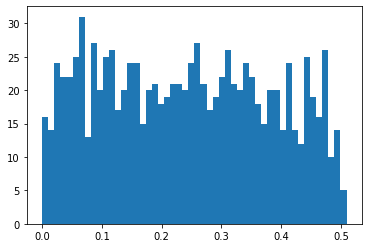

In [112]:
# bootstrapped p-values
plt.hist(output, bins=50);

In [119]:
len(output)

1000

# Archive

## simulate_experiments function without dask

In [ ]:
def simulate_experiments(df, num_experiments=10000, randomization_unit='user'):
    p_values = []
    
    for x in range(0, num_experiments):
        if randomization_unit == 'user':
            users = df.user.unique()
            users_df = pd.DataFrame({'user': users, 'assignment': np.random.randint(0, 2, size=len(users))})
            df_w_assignments = pd.merge(df, users_df, how='inner', on='user')
        elif randomization_unit == 'session':
            df_w_assignments = df.copy()
            df_w_assignments['assignment'] = np.random.randint(0, 2, size=df.shape[0])
        else:
            raise ValueError("randomization unit must be 'session' or 'user'")

        control_samples = df_w_assignments[df_w_assignments.assignment == 0].session_converted.count()
        control_successes = df_w_assignments[df_w_assignments.assignment == 0].session_converted.sum()

        test_samples = df_w_assignments[df_w_assignments.assignment == 1].session_converted.count()
        test_successes = df_w_assignments[df_w_assignments.assignment == 1].session_converted.sum()

        zscore, p_value = two_proportions_test(
            control_successes, 
            control_samples,
            test_successes, 
            test_samples,
        )

        p_values.append(p_value)
        
    return p_values

## Uniform Data - Simulating A/A Test - Session Level Randomization

In [ ]:
num_sessions = 5000
conversion_rate = 0.1


p_values = []
bayesian_probas = []
for x in range(0, 2500):
    assignments = np.random.randint(0, 2, size=num_sessions)
    converted = np.random.choice(
        a=[0, 1], 
        p=[conversion_rate, 1-conversion_rate], 
        size=num_sessions
    )
    df = pd.DataFrame({'assignment': assignments, 'converted': converted})

    control_samples = df[df.assignment == 0].converted.count()
    control_successes = df[df.assignment == 0].converted.sum()

    test_samples = df[df.assignment == 1].converted.count()
    test_successes = df[df.assignment == 1].converted.sum()
    
    zscore, p_value = two_proportions_test(
        control_successes, 
        control_samples,
        test_successes, 
        test_samples,
    )
    
    p_values.append(p_value)
    
    p_test_gt_control, p_control_gt_test = bayesian_rate_comparison(
        control_successes, control_samples, test_successes, test_samples
    )
    bayesian_probas.append((p_test_gt_control, p_control_gt_test))

In [ ]:
# 5,000
frequentist_fpr = len([p for p in p_values if p <= 0.05]) / len(p_values)
bayesian_fpr = (
    len([1 for p_t, p_c in bayesian_probas if p_t >= 0.975 or p_c >= 0.975]) 
    / len(bayesian_probas)
)

print(f"Frequentist false positive rate: {frequentist_fpr:0.2%}")
print(f"Bayesian false positive rate: {bayesian_fpr:0.2%}")

In [ ]:
# 50,000
frequentist_fpr = len([p for p in p_values if p <= 0.05]) / len(p_values)
bayesian_fpr = (
    len([1 for p_t, p_c in bayesian_probas if p_t >= 0.975 or p_c >= 0.975]) 
    / len(bayesian_probas)
)

print(f"Frequentist false positive rate: {frequentist_fpr:0.2%}")
print(f"Bayesian false positive rate: {bayesian_fpr:0.2%}")

In [ ]:
# 500,000
frequentist_fpr = len([p for p in p_values if p <= 0.05]) / len(p_values)
bayesian_fpr = (
    len([1 for p_t, p_c in bayesian_probas if p_t >= 0.975 or p_c >= 0.975]) 
    / len(bayesian_probas)
)

print(f"Frequentist false positive rate: {frequentist_fpr:0.2%}")
print(f"Bayesian false positive rate: {bayesian_fpr:0.2%}")

# Statistical Tests

## Frequentist

In [ ]:
def two_proportions_test_delta_method(
    user_conversion_counts_a, 
    user_session_counts_a,
    user_conversion_counts_b,
    user_session_counts_b,
):

    Y_hat_c = np.sum(user_conversion_counts_a) / np.sum(user_session_counts_a)
    Y_hat_t = np.sum(user_conversion_counts_b) / np.sum(user_session_counts_b)

    n = user_session_counts_b.shape[0] + user_session_counts_a.shape[0]

    tau = Y_hat_t - Y_hat_c
    e_c2 = (
        np.var(user_conversion_counts_a)/np.mean(user_session_counts_a)**2 
        + np.mean(user_conversion_counts_a)**2/np.mean(user_session_counts_a)**4*np.var(user_session_counts_a) 
        - 2*np.mean(user_conversion_counts_a)/np.mean(user_session_counts_a)**3*np.cov(user_conversion_counts_a, user_session_counts_a)[0][1]
    )

    e_t2 = (
        np.var(user_conversion_counts_b)/np.mean(user_session_counts_b)**2 
        + np.mean(user_conversion_counts_b)**2/np.mean(user_session_counts_b)**4*np.var(user_session_counts_b) 
        - 2*np.mean(user_conversion_counts_b)/np.mean(user_session_counts_b)**3*np.cov(user_conversion_counts_b, user_session_counts_b)[0][1]
    )

    var_tau = n**-1*(e_c2 + e_t2)

    zscore = np.abs(tau) / np.sqrt(var_tau)
    one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(zscore)
    pvalue = one_side * 2    
    return zscore, pvalue



In [ ]:
def two_proportions_test(success_a, size_a, success_b, size_b):
    """
    http://ethen8181.github.io/machine-learning/ab_tests/frequentist_ab_test.html#Comparing-Two-Proportions
    
    A/B test for two proportions;
    given a success a trial size of group A and B compute its zscore and pvalue
    
    Parameters
    ----------
    success_a, success_b : int
        Number of successes in each group
        
    size_a, size_b : int
        Size, or number of observations in each group
    
    Returns
    -------
    zscore : float
        test statistic for the two proportion z-test

    pvalue : float
        p-value for the two proportion z-test
    """
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    prop_pooled = (success_a + success_b) / (size_a + size_b)
    var = prop_pooled * (1 - prop_pooled) * (1 / size_a + 1 / size_b)
    zscore = np.abs(prop_b - prop_a) / np.sqrt(var)
    one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(zscore)
    pvalue = one_side * 2
    return zscore, pvalue

# zscore, p_value = two_proportions_test(
#     control_successes, 
#     control_samples,
#     test_successes, 
#     test_samples,
# )

# if p_value <= 0.05:
#     print ("Reject null hypothesis, conversion rates are different")
# else:
#     print ("Accept null hypothesis, samples are NOT different")

## Bayesian

In [ ]:
def bayesian_rate_comparison(
    control_successes, control_samples, test_successes, test_samples
):

    num_samples = 50000

    control_samples = np.random.beta(
        control_successes, 
        control_samples - control_successes, 
        size=num_samples
    )

    test_samples = np.random.beta(
        test_successes, 
        test_samples - test_successes, 
        size=num_samples
    )

    p_test_gt_control = (test_samples > control_samples).mean()
    p_control_gt_test = (control_samples > test_samples).mean()

    return p_test_gt_control, p_control_gt_test

# p_test_gt_control, p_control_gt_test = bayesian_rate_comparison(
#     control_successes, control_samples, test_successes, test_samples
# )
    
# if p_test_gt_control >= 0.975 or p_control_gt_test >= 0.975:
#     print ("Reject null hypothesis, conversion rates are different")
# else:
#     print ("Accept null hypothesis, samples are NOT different")

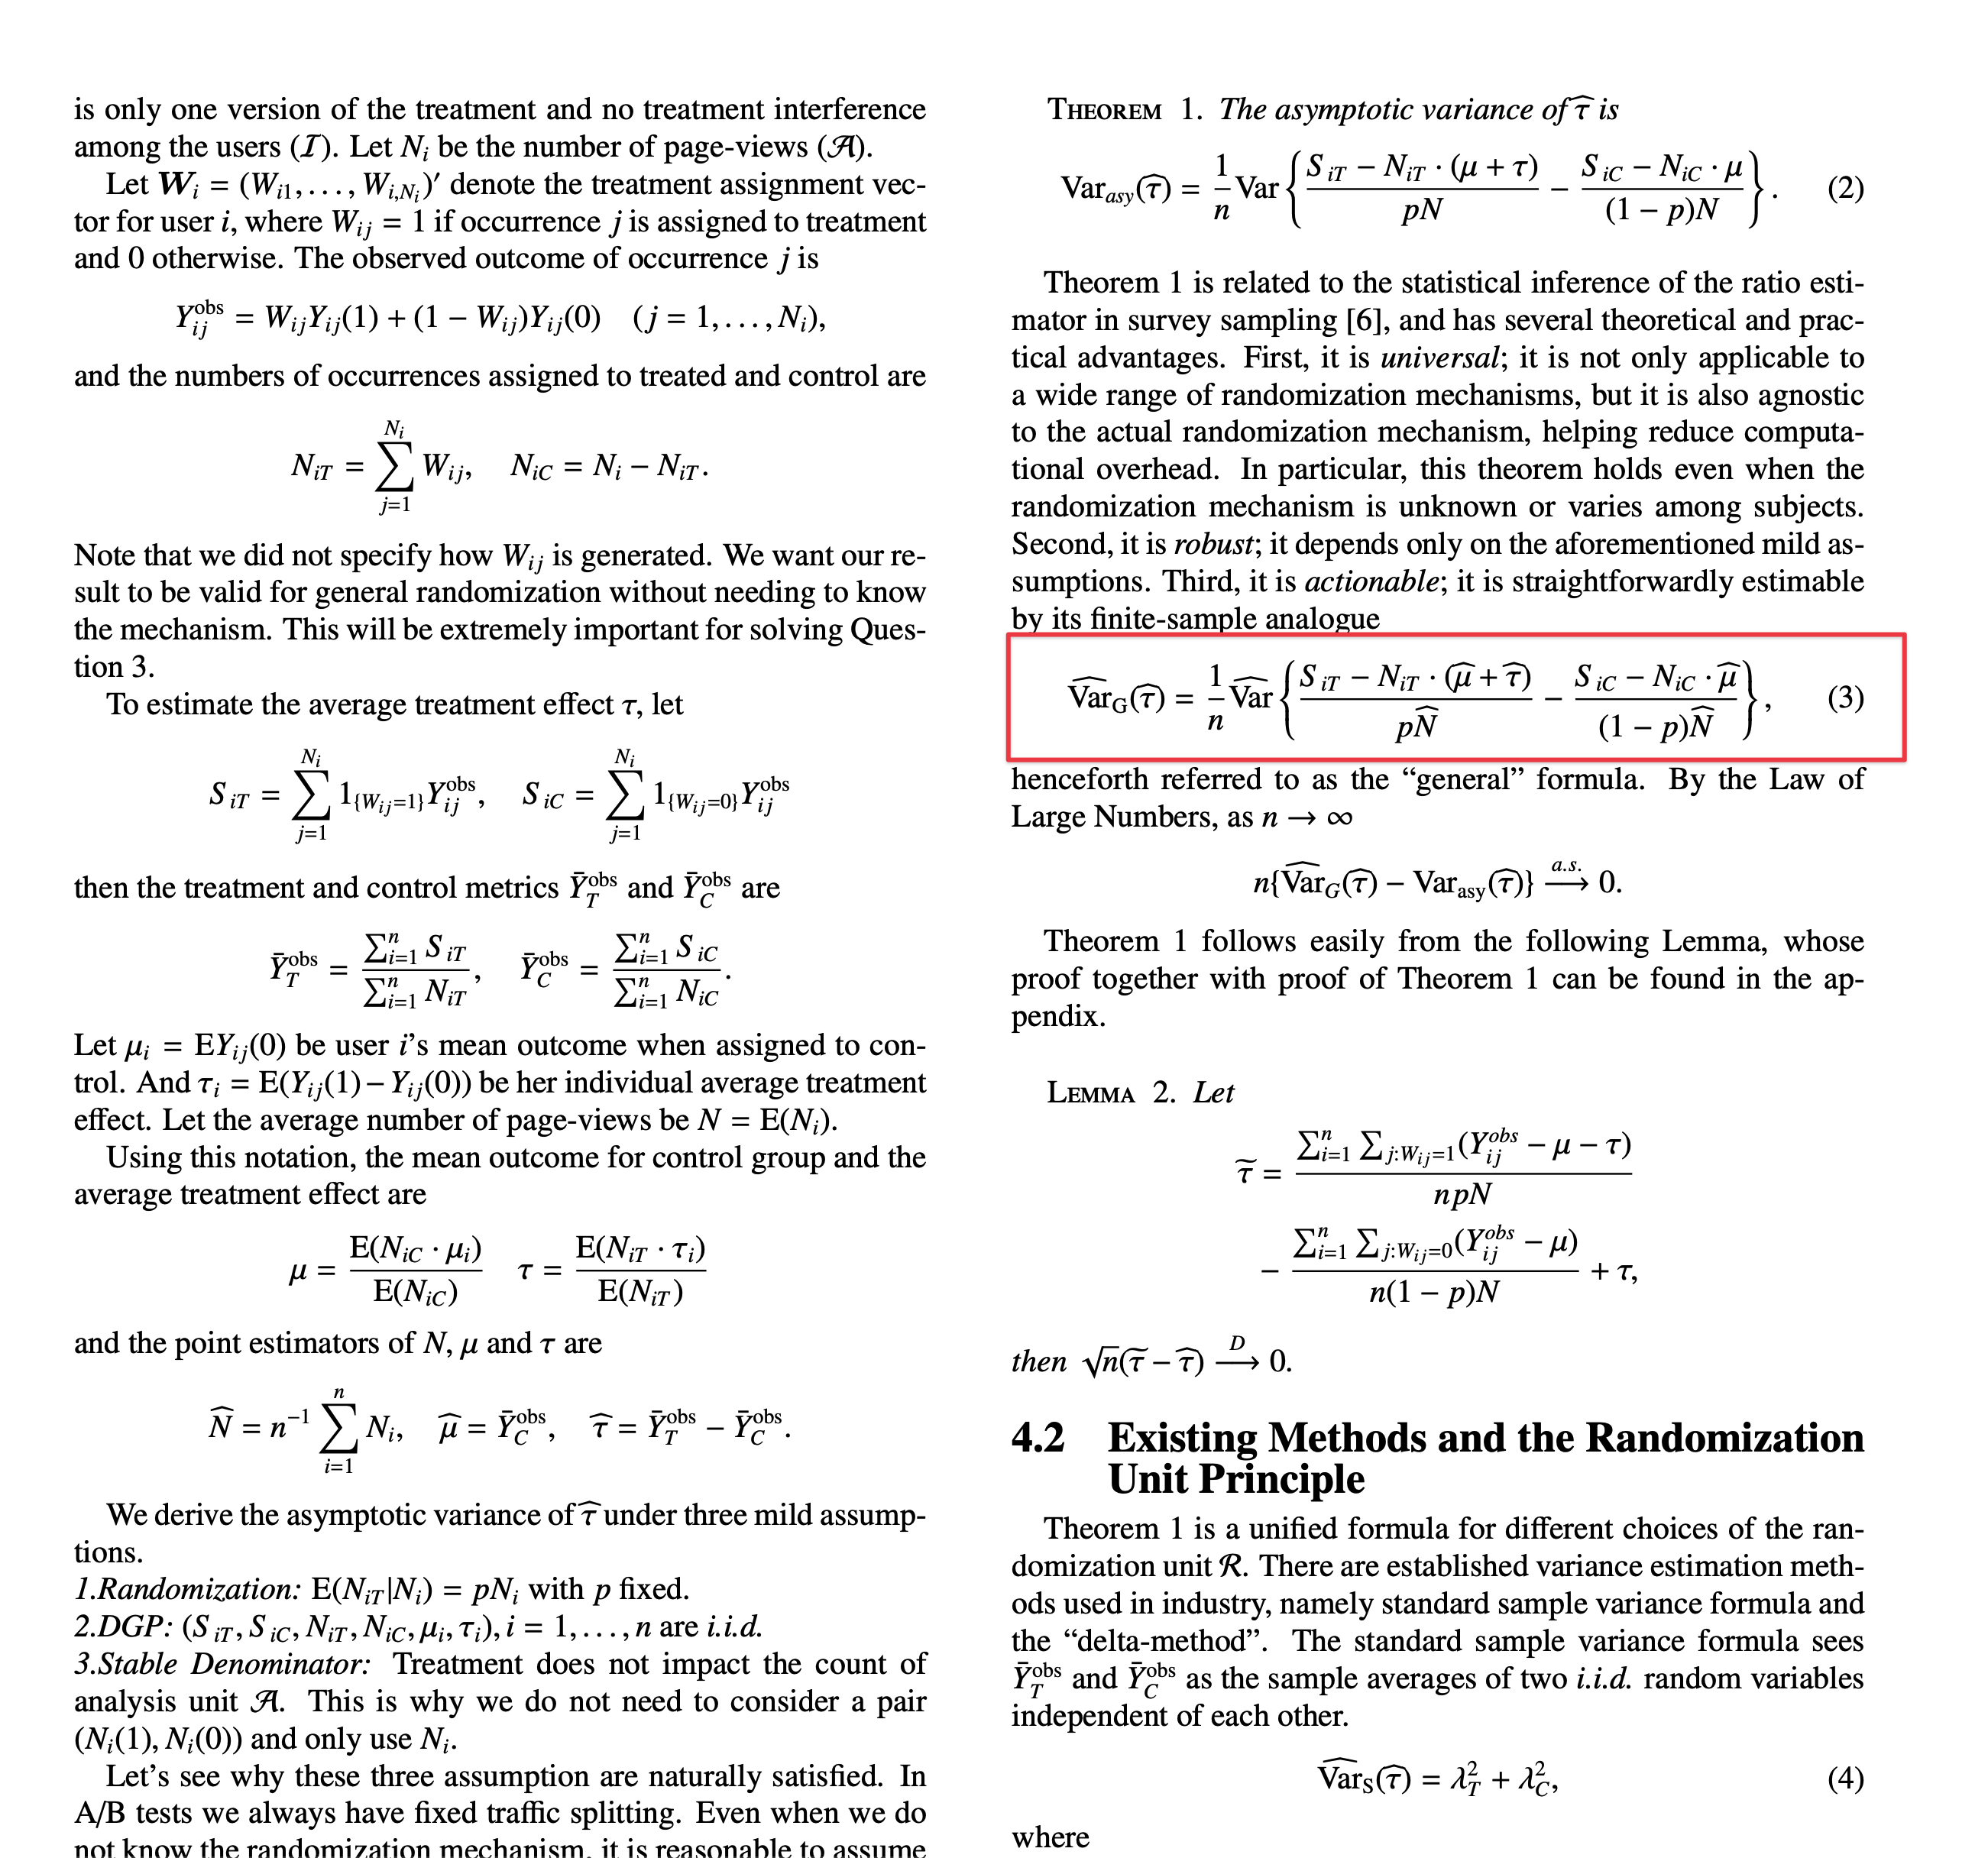

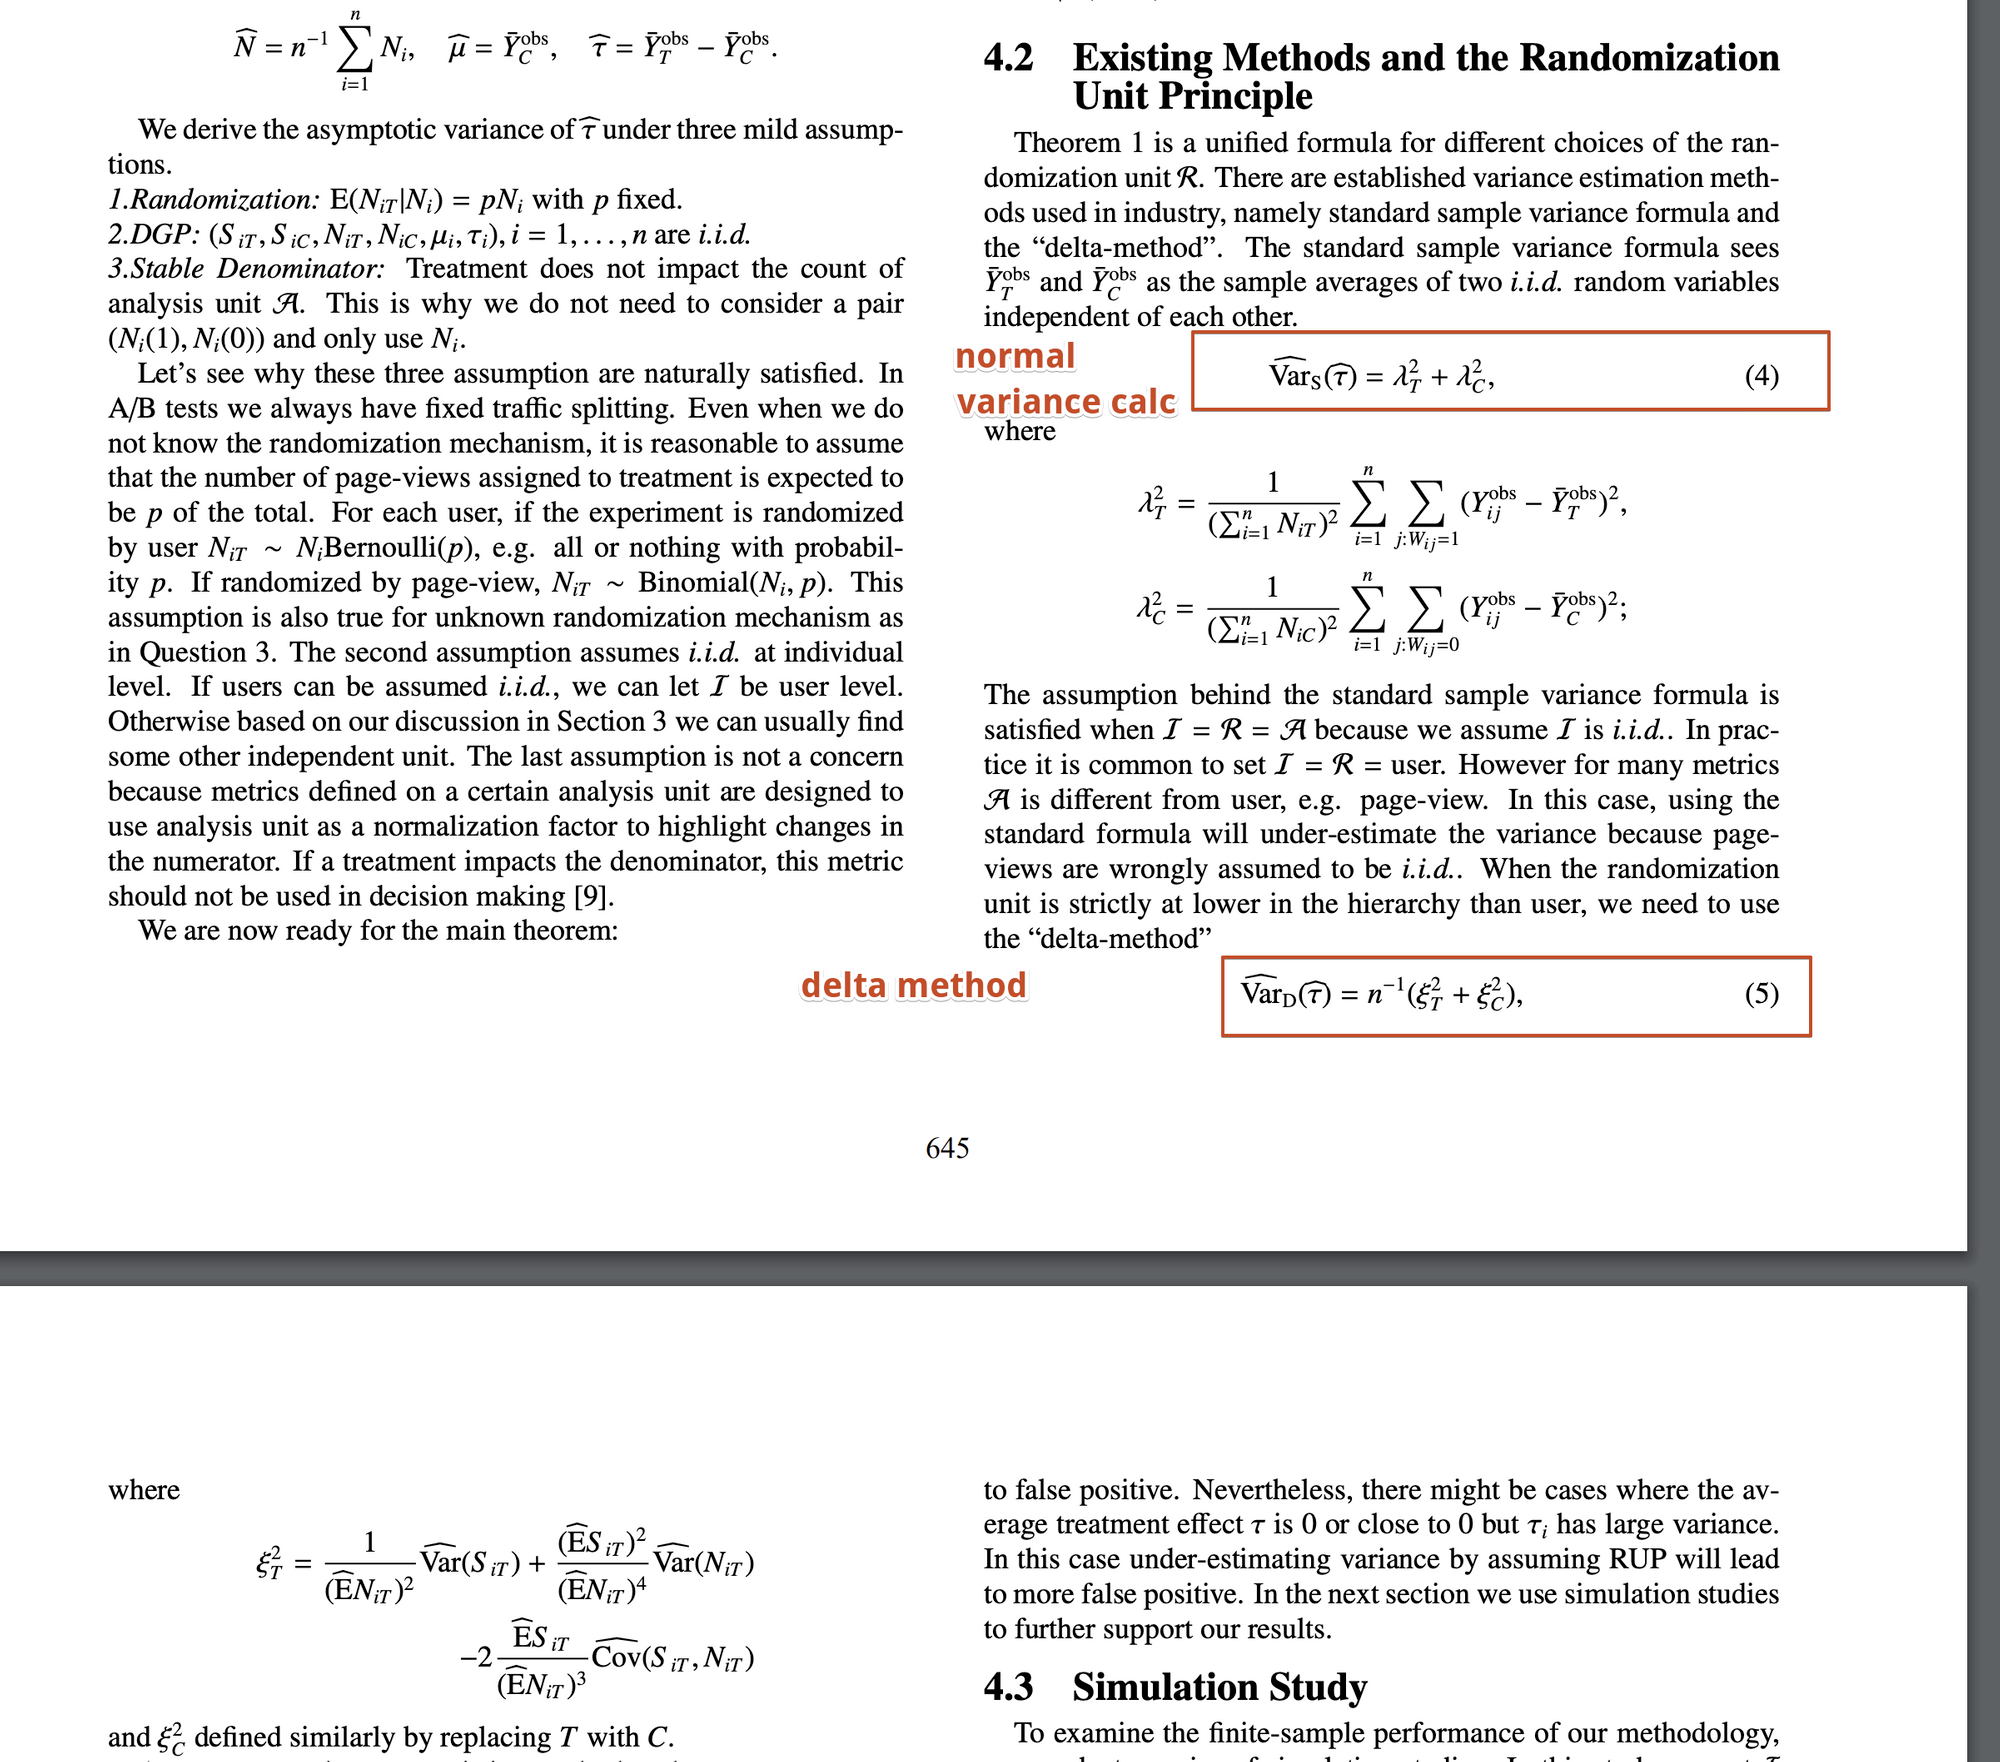